https://arxiv.org/pdf/1412.6572.pdf  
https://arxiv.org/pdf/1801.00553.pdf  
http://karpathy.github.io/2015/03/30/breaking-convnets/  


In [1]:
%load_ext autoreload
%autoreload 1

In [25]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from PIL import Image
from torchvision import transforms
from skimage.measure import compare_ssim

import torch
from torch import nn
from torch.autograd import Variable
from student_net_learning.utils import get_model
from attacker import reverse_normalize, FGSM_Attacker
%aimport attacker

from IPython.display import Image as Embed_Image, YouTubeVideo

Download and unpack images:  

In [ ]:
!python downloader.py --root ./data --main_imgs --submit_list --pairs_list  

In [45]:
!unzip ./data/imgs.zip -d ./data/imgs

Archive:  ./data/imgs.zip
 extracting: ./data/imgs/5c9bd196c5b1ff710b8b9d6ba5b9c7b6fcf462e9.jpg  
 extracting: ./data/imgs/1fdc34bfbc7991268f5522c948b91bde2c090bec.jpg  
 extracting: ./data/imgs/d69bd34a4ea9ecd342e91328704bd9626951a2b7.jpg  
 extracting: ./data/imgs/a12d74339238710ddd989112303f24aeca469e2d.jpg  
 extracting: ./data/imgs/74e9a821f815cf47a25f3f1bc20047634768c656.jpg  
 extracting: ./data/imgs/7f19ad2e035e793c0b008096c22601d7b01f9bc0.jpg  
 extracting: ./data/imgs/a9a292e8dd7f34f7169b9033af238232e80f7f34.jpg  
 extracting: ./data/imgs/cafb48e42fb4a2b9eb1254f6ccd1e4bf5e4db7bc.jpg  
 extracting: ./data/imgs/dc51e33523b78ad29a1f222abe8a94f03e7dcb3f.jpg  
 extracting: ./data/imgs/15152b7f9bf05317a17a46edbf4c2b2a302e79ad.jpg  
 extracting: ./data/imgs/543c8e4a3a1eb455485095cfd7d5be53ad9d1436.jpg  
 extracting: ./data/imgs/dfad0e71659056a57da8f4ef8cc7faba8fe3b147.jpg  
 extracting: ./data/imgs/2d10e9d7600196582dac55f8a90e51b1aa618701.jpg  
 extracting: ./data/imgs/7dea58470a091

 extracting: ./data/imgs/97a9c3b113369f1a41844068494b45cfc582f902.jpg  
 extracting: ./data/imgs/ba8271bd61880ccdff616f14486d96ae1ff12b5e.jpg  
 extracting: ./data/imgs/1a1a2d299ea65ae82d894a4336c7f9f2ab9e9ec7.jpg  
 extracting: ./data/imgs/4c4e6cc30804c5916f9b4faa130cdf44efb8f263.jpg  
 extracting: ./data/imgs/8a7d99da215c22b2954cec06fd0b47e4ef3ae988.jpg  
 extracting: ./data/imgs/3f071e1d8b963433edee49b54e6fef9949e91350.jpg  
 extracting: ./data/imgs/66eda679c075924d490c20ddf2802cb74b30de50.jpg  
 extracting: ./data/imgs/3ee788460dfb393955c8158da3e6749dcd7b2c5b.jpg  
 extracting: ./data/imgs/18059868c3731afd8a948b71e37c648cc1b5792e.jpg  
 extracting: ./data/imgs/2188814846061714f6faf53f47941ccff0843ba8.jpg  
 extracting: ./data/imgs/cc278d804129e592c2e34e6f95f185d60363dfa9.jpg  
 extracting: ./data/imgs/bb9d9d77b1b172abfc32fa65f0169989d5c97562.jpg  
 extracting: ./data/imgs/26a0da3586773a3a5191b69ec3e47de8dbc5ec3d.jpg  
 extracting: ./data/imgs/4c5749727c32f77e8561c1fcb2cf9494f8ca23e

 extracting: ./data/imgs/70cd5ebbcaf8624e05862e6027163824a505d3c8.jpg  
 extracting: ./data/imgs/1342d92472bcf57eec0e70c6349fb49a8076fec1.jpg  
 extracting: ./data/imgs/3d34ed2cd81fcd04bfda46752569c5123924d45f.jpg  
 extracting: ./data/imgs/9d0e02adbb52ae811f6dbc0fbceac94d6a341fa4.jpg  
 extracting: ./data/imgs/17d91448f87361a9c69e953a19dbf9062e80a136.jpg  
 extracting: ./data/imgs/b76de97c7f92f4ffe6173f3cab28e461c5d9aa65.jpg  
 extracting: ./data/imgs/efcd1d903550429a40c7877c4b9bb7a92afc08f1.jpg  
 extracting: ./data/imgs/815237bd41221d0318b54dbfd09566c19c9daf74.jpg  
 extracting: ./data/imgs/5e192c95c0df2ab9161771b49378d5e20fa0af28.jpg  
 extracting: ./data/imgs/1d7cbc110159e44cdeeeab7b4ac2c95bbc781e23.jpg  
 extracting: ./data/imgs/11814358f41a7269aa3dda77dccda61256bdd3b7.jpg  
 extracting: ./data/imgs/815bad38b12d737e62f97289fccc459058e19450.jpg  
 extracting: ./data/imgs/a30097ca5770a7fd47705154eac18c1fa3e9d7f3.jpg  
 extracting: ./data/imgs/839d41c2b19921fe38bcd69762a368c653efa5f

 extracting: ./data/imgs/f767f6a371b073ee833c076a218395e157429248.jpg  
 extracting: ./data/imgs/1cff4e7c79eb73d96331c25dd7b6ccf95eeea052.jpg  
 extracting: ./data/imgs/1635b0dc505d0ae0d27afa51f38d9e12cef3ac14.jpg  
 extracting: ./data/imgs/b662b3cf99bfda6f0acaf818249ab0c150f265ad.jpg  
 extracting: ./data/imgs/7dfd21dcc0fdd85d74d20c3c7f5ea38969dcc88b.jpg  
 extracting: ./data/imgs/6b61fe9a03ac4a6a0b78d998c9b9eab0351f16c7.jpg  
 extracting: ./data/imgs/59c5f7edda5358e3a94ed092bb43971078f6e5eb.jpg  
 extracting: ./data/imgs/4a076b51ac37c402607f6897c033ad8531398059.jpg  
 extracting: ./data/imgs/76efdf6e0dbb58036c96e7a6bd2039c98796d30c.jpg  
 extracting: ./data/imgs/242b14d7914688c90a58a6471f104228fb933a33.jpg  
 extracting: ./data/imgs/7ea0c4f9f609df2fe69d1d70e3918dedbfe83f16.jpg  
 extracting: ./data/imgs/df0d457dff551cb3c9585f2aa712d5e0feb7066f.jpg  
 extracting: ./data/imgs/782f7209c3a598d3f65212b3c0b5bc3bdcddfacb.jpg  
 extracting: ./data/imgs/27989662c3c67d065e937b67f337dfa2123b335

 extracting: ./data/imgs/ffb65bae1444c5a1caebdcdefd660bf9f1a139ac.jpg  
 extracting: ./data/imgs/f808a705243a90a484998e906f3f56540bee8df1.jpg  
 extracting: ./data/imgs/916501e95eecbcd8cc3f468c32505c149a5d26cc.jpg  
 extracting: ./data/imgs/26efb386396a65831ed9811b6903286e9eb6406d.jpg  
 extracting: ./data/imgs/c18543014fe98feda085119a95b82124f888f103.jpg  
 extracting: ./data/imgs/70bc5c7e1f82fcd9f4e6b3dc5f70a1dd4849b21f.jpg  
 extracting: ./data/imgs/25e3e29b0b7a33c52d38dee79299adf58397d196.jpg  
 extracting: ./data/imgs/66e38f4b48f549bad7fc722f15ec6270b21b2af7.jpg  
 extracting: ./data/imgs/2cf2e394b1a4fa1d4f71a11deb5eaccfd757d668.jpg  
 extracting: ./data/imgs/2249d6d2dab8e298a720191a347889e7739d8184.jpg  
 extracting: ./data/imgs/a0e8e796e25399b481b3406793debadf80cf741a.jpg  
 extracting: ./data/imgs/fa15e057bd0308aa967e92e513960b28bab650f0.jpg  
 extracting: ./data/imgs/e7f233a0dbcfd6b00f80b185f2098d4f52070de8.jpg  
 extracting: ./data/imgs/a74295b1e9d00b29593e89030d6c88c3e6f6b14

 extracting: ./data/imgs/d063d03904c9e38c0c702f1abd44d4ba42a48700.jpg  
 extracting: ./data/imgs/bf8d61345a1a7ed636b663440c379cce22a192a3.jpg  
 extracting: ./data/imgs/25b0a60d693b7131127652ab48fba05b26a24441.jpg  
 extracting: ./data/imgs/60a5b02c3f8cef5562b71b0f22a98501d5ef8122.jpg  
 extracting: ./data/imgs/4cd56e326f6435b0bdf27a6870ccceca36e33249.jpg  
 extracting: ./data/imgs/6912c906e886b8452014cb9c535d0f91db7393ef.jpg  
 extracting: ./data/imgs/2ffcde751cca4b9028d34b53b5410ae5342919c3.jpg  
 extracting: ./data/imgs/6db3d64b78a68bf4ec752af4ff93066f07207e21.jpg  
 extracting: ./data/imgs/c062484c1c638cdeb7e9a180af060c230413777f.jpg  
 extracting: ./data/imgs/59dcc444247270faf808c3c3acda82180aa0162a.jpg  
 extracting: ./data/imgs/b8dc65954d7ed5445b327ac935f36f04bf8da689.jpg  
 extracting: ./data/imgs/fca261b8b0bff077db749072ac4714447052875c.jpg  
 extracting: ./data/imgs/b8397fb0bf15e2bc8a62d8b5c1ad24b090ae12e6.jpg  
 extracting: ./data/imgs/f38babb669a69be0a320c7dab49d26f3d1c947e

 extracting: ./data/imgs/61febb60a09e03ff9cded833955237a252967984.jpg  
 extracting: ./data/imgs/b4e6ce750bcb9a1b8b583435ab75843978b08d7f.jpg  
 extracting: ./data/imgs/f3306a1edf821ba4c8f8a25be065b74883185e50.jpg  
 extracting: ./data/imgs/3c7df6f3df336ff64b3939d3feb52d91d5a70898.jpg  
 extracting: ./data/imgs/7e61efcfc5ec24ba6877b913b855978d12eb0d1d.jpg  
 extracting: ./data/imgs/6f57694ef3e597e9fede089b2c1e07dedd0a4b4f.jpg  
 extracting: ./data/imgs/8ef26633038295a6d8a9bfd6aba1063813b47d6d.jpg  
 extracting: ./data/imgs/7ed36d3adde7ccaa25107229da8e1af5b5f04242.jpg  
 extracting: ./data/imgs/041ef8b1019a82b3d1ec26a844de206eaf7ce89a.jpg  
 extracting: ./data/imgs/20275b19386855f6e380ea5377f44e4c7051c4a0.jpg  
 extracting: ./data/imgs/64e8f38ec6b4d636119f144d4201a16d98b62824.jpg  
 extracting: ./data/imgs/7ed60b75f7a17652a80288b4847b5cafb12f9c4b.jpg  
 extracting: ./data/imgs/c38fc1f9b3ae4d1d6523692ccf04040862369089.jpg  
 extracting: ./data/imgs/c8a37a029f0fbd6127af29c86a32b21851deadd

 extracting: ./data/imgs/2f27eef45c3a02bcff3329352aa19efaf8faa91c.jpg  
 extracting: ./data/imgs/4fd3e4b12da08a8faa1b9c4a7e1e01d4ce76dbf2.jpg  
 extracting: ./data/imgs/c9e40a6182ee867bb84e305012c7a2a49449d4b7.jpg  
 extracting: ./data/imgs/5e5c52f54c7ca9c76befa849012957e1db9ee3c3.jpg  
 extracting: ./data/imgs/9085d99e5085b7086ce49225aa234c80dab4a311.jpg  
 extracting: ./data/imgs/0dad33bb8f6786c4895d5bc79d1a96fc69092a2f.jpg  
 extracting: ./data/imgs/2c937063f3d312c14321b33e35feaa91754c80fa.jpg  
 extracting: ./data/imgs/a810c8b4c7a58c75940012228f87191e0efeb63f.jpg  
 extracting: ./data/imgs/97030a8ffe7e4aeba225b742b44b7faf2d5f3cf4.jpg  
 extracting: ./data/imgs/f527f08a6e923e62eeeefc7ca1688d1686668675.jpg  
 extracting: ./data/imgs/43a35ab6c05a7e54d17f2babd2b220ee04979012.jpg  
 extracting: ./data/imgs/cce4d9bfa68ca8c058d47c798d9418645755f890.jpg  
 extracting: ./data/imgs/c59678982f8ff184749ed8b196434fa49b8c8861.jpg  
 extracting: ./data/imgs/20d1ccec9c6ab75989488944d16cc6241f3c551

 extracting: ./data/imgs/0053642807fe382abcd37dff1235fdc57a6790fb.jpg  
 extracting: ./data/imgs/4ea553901d0b44c59f74b33a06364d6cd7bad103.jpg  
 extracting: ./data/imgs/21e0f03ea123f62a9010efd9e6f3fec79d7c999e.jpg  
 extracting: ./data/imgs/a8a801a107e90c67237db1076dd65e479ec1fd85.jpg  
 extracting: ./data/imgs/a2760d3690d4c14953b544a1c832246aefd6e5cc.jpg  
 extracting: ./data/imgs/f3c86ee51778d5d055361d16c2193b0d483cd878.jpg  
 extracting: ./data/imgs/4b59fdf940280d1bbab287328247f832e6782cef.jpg  
 extracting: ./data/imgs/b9eaa7ce75d18bb1965c807c29a04e3a2bc62458.jpg  
 extracting: ./data/imgs/be984e873891ccb8f8244e55956ac3ebf0dca4d9.jpg  
 extracting: ./data/imgs/f8d3f5478588cba9c0caf90b5887601b2d5f0ba3.jpg  
 extracting: ./data/imgs/9cea011dffa1039c25cbc25a2a8136e808875d4e.jpg  
 extracting: ./data/imgs/e42c6896940d86ff2ae6e8481fb5da058b6682a2.jpg  
 extracting: ./data/imgs/3567f54d76f496a746169261b8347d1ac0be04cd.jpg  
 extracting: ./data/imgs/5dac300c9604e848843acfe48064c44ccf4b993

 extracting: ./data/imgs/48616b93dca1cc3279efc235cdbc8623e0a9b842.jpg  
 extracting: ./data/imgs/09ffe24de46ae4df2de5ee2db8cf5dc2a142d890.jpg  
 extracting: ./data/imgs/8f95baa8ee827df0567ffc0616fca8aba40b4dae.jpg  
 extracting: ./data/imgs/cc0b509c658a785df3c8cf28057270a8a64525dd.jpg  
 extracting: ./data/imgs/c9f4ffdb8bc1fc15e502eb16c63a6b321bcc1352.jpg  
 extracting: ./data/imgs/3c495d2362adf0b34d7e11556a879c7eae85c685.jpg  
 extracting: ./data/imgs/bd0fb34089d490722a6580fd5d8aea875c324fe2.jpg  
 extracting: ./data/imgs/06ab1e1ba405fd3572162064a37ff00d270b38eb.jpg  
 extracting: ./data/imgs/da27b8d6864b7224d3fe999e0f2c6c3593cd2439.jpg  
 extracting: ./data/imgs/005b19c9012b8d1c2bb4732d654eb3e1e9bdf980.jpg  
 extracting: ./data/imgs/df8668ec394f4fac4027eba48c7a5f26ddd4347c.jpg  
 extracting: ./data/imgs/0bdccbd64b2b11a2a151f304332a8ab1a1a77952.jpg  
 extracting: ./data/imgs/8177963cd2fb47fa23294748a009272f6e0b2ede.jpg  
 extracting: ./data/imgs/1380f55defc41a142a1ff4aa4e548cc102901f3

 extracting: ./data/imgs/4b9af5c259685947ad064df49f55fd57194c246c.jpg  
 extracting: ./data/imgs/187ed88d3514fc0f0acc02bc5f54f827a5e867fb.jpg  
 extracting: ./data/imgs/f22b44b1312ce8cc8d951d864c23d0d97cae853f.jpg  
 extracting: ./data/imgs/7180c278d76f1a5a8a039bb42e3e20557ad381b6.jpg  
 extracting: ./data/imgs/e29a06a957686424e4e25e3be3aef90a2af5a6f6.jpg  
 extracting: ./data/imgs/4659c91d3a6edeb846b5b2156083aa65f021fed9.jpg  
 extracting: ./data/imgs/d349f27dc0c99674a34ba254ee8e6eff640dec09.jpg  
 extracting: ./data/imgs/c640a8dd9d8a9f5e3c614381f296ee0e07ceb30a.jpg  
 extracting: ./data/imgs/0382484a97b520e1968c446bddd3a671ee64072e.jpg  
 extracting: ./data/imgs/367615f73fb7f60e8956fadec7bfafbd79f6166b.jpg  
 extracting: ./data/imgs/e66ec502760c92cc7d1f57edc05d36b674d2ae04.jpg  
 extracting: ./data/imgs/bd4e705eaec4e446de37aa61b81976014c97c76f.jpg  
 extracting: ./data/imgs/576d5416188e68ec94302ea03ecd24145be86bc1.jpg  
 extracting: ./data/imgs/159db4fe518ae07bddc6dfc4e9de1626f1b9c62

 extracting: ./data/imgs/896f48c6ed2f68238e741e8692ff815bc0b4ec90.jpg  
 extracting: ./data/imgs/cf8064e951c7ecaa8b6dd78b5af3e99907bad218.jpg  
 extracting: ./data/imgs/a34060c430d7ac37ceb263a6fac763e69116a817.jpg  
 extracting: ./data/imgs/13a96c1735a3f19e2922c2312ee0df360bc0b3fa.jpg  
 extracting: ./data/imgs/c24679751f25a2710e4f410d8b3e2387b3733668.jpg  
 extracting: ./data/imgs/f9a3480a8fa3aa726c325dcc9ef3c4ff56012bda.jpg  
 extracting: ./data/imgs/8841f99716c87d1deac70a46cba0521396c142ac.jpg  
 extracting: ./data/imgs/ef334f9edec8cdede31c59d2dc6d889e0bfd514c.jpg  
 extracting: ./data/imgs/2f1c301d15634286dd004a8d9c223b44fad97171.jpg  
 extracting: ./data/imgs/53653015d7132eb8f259bdb259d17b6f032ccd5d.jpg  
 extracting: ./data/imgs/5bbc54589f68e04c520e89c3beeceb61d6dc509c.jpg  
 extracting: ./data/imgs/e28432c2c4bcc6f6d0c2a3d6ac630445e5c84a82.jpg  
 extracting: ./data/imgs/4130c74aae0d05269212ced24340c2d82528eded.jpg  
 extracting: ./data/imgs/66f46e07748e9f80430c72b51e5b0e492a21963

 extracting: ./data/imgs/473c67d5e37021552894efabdade545b6b915dbb.jpg  
 extracting: ./data/imgs/8b82cb92e3b836b138d140e0bfaef7fbadb98fd6.jpg  
 extracting: ./data/imgs/53b6b157467beef5724a9c93ccda922951f8b1da.jpg  
 extracting: ./data/imgs/7611e111bc333445be1e6f6a177fc0f2b1f33758.jpg  
 extracting: ./data/imgs/9d989cc1a88a7880caffe60e34cba0e1603a376d.jpg  
 extracting: ./data/imgs/c582bb9382c2d2597071feaaaddc2137faa363eb.jpg  
 extracting: ./data/imgs/36c7586c9f02e5b953e71086ed5a5cf5c676e707.jpg  
 extracting: ./data/imgs/25dd7b9bf7771d1ec7e19daeba31c6e75404c2b0.jpg  
 extracting: ./data/imgs/23c2b78484e055c9c0a2bee39eaf94d54dc660d5.jpg  
 extracting: ./data/imgs/b28c2dd2ac97f2c062cb90b13da54b9e468b29ef.jpg  
 extracting: ./data/imgs/f01352ecab94e4ac41e7ff6ef074a9c4f242b233.jpg  
 extracting: ./data/imgs/932d3fb590aaae507915411d07239fb93cad47d0.jpg  
 extracting: ./data/imgs/f81d28a05f962916c0257aa0c15472dab0f35955.jpg  
 extracting: ./data/imgs/04dedbb442ebee4b946df5d6ee12e02d9826fc4

 extracting: ./data/imgs/091c8ad3600524482eb610726ca6f13b3a3bc55d.jpg  
 extracting: ./data/imgs/69da4595fbb168c0edb348c7c307e7de677966d0.jpg  
 extracting: ./data/imgs/c6b5379578a747f8989ecb2e0a7ca34acbb56740.jpg  
 extracting: ./data/imgs/0a4dc1617a81abb6d1146356f028cb57ec906540.jpg  
 extracting: ./data/imgs/2329e7777492e7ba2b3468e3fc6d0c3f1cd2590a.jpg  
 extracting: ./data/imgs/7abba70cabb5a1731cadb7eb4170379a40a5149c.jpg  
 extracting: ./data/imgs/0634887dd2d3627ef1da3e8f8d92468a727cde3b.jpg  
 extracting: ./data/imgs/d7392e7d8cdb2cc704cce372e1bf38e960984bf7.jpg  
 extracting: ./data/imgs/6b82505acbda76b2285d0bbb313f91cce9cd1af9.jpg  
 extracting: ./data/imgs/8f9faa1124481d2749ca5ec90c8762fb69a244b7.jpg  
 extracting: ./data/imgs/b9c6ea4811015e2538395039147fb5d54800d082.jpg  
 extracting: ./data/imgs/1de4eb9dc7fa7d2700dbaa869b24d698b5a0b438.jpg  
 extracting: ./data/imgs/714fc3bf2cf3ce296a7744b630e69f552500f8d5.jpg  
 extracting: ./data/imgs/8bcae2dc778562019b94a1b29f524a9acf7cb89

 extracting: ./data/imgs/4b2a935adb3b3ee3ddf913eab3b62b56382cc9bd.jpg  
 extracting: ./data/imgs/2a4a11aa07613f049f9802643dcd8d550641ccdf.jpg  
 extracting: ./data/imgs/b55d72a7a18ade6c113495e34bf120f1fc784806.jpg  
 extracting: ./data/imgs/5e6c1c21b7d5e58647a83c328efc36727da9903a.jpg  
 extracting: ./data/imgs/916b6ff40d88794859d50f31cbaa24d0f53c2689.jpg  
 extracting: ./data/imgs/9140d6a251cdf742ca97003e053c6e1778a3cf2e.jpg  
 extracting: ./data/imgs/f090dd4f44d1edab216467962befaf138dbbc1ff.jpg  
 extracting: ./data/imgs/1a443d0f253d0ce3158e49f8d2cc29d3c5d38577.jpg  
 extracting: ./data/imgs/ebccd7004e35d8bec128e727cf3b971ced529828.jpg  
 extracting: ./data/imgs/8d6bf116196339ff85e7e7d63bed40ad830176d0.jpg  
 extracting: ./data/imgs/50eab3994a75543281c498113e3c3d3144e4e79b.jpg  
 extracting: ./data/imgs/7dc7bf0e51baf1c16cb4a924bea503101c4a51ce.jpg  
 extracting: ./data/imgs/3f2c71ca6dba55c71466ef1e94bd3656ca4ffd04.jpg  
 extracting: ./data/imgs/bff031090c5f10e8e38c938f9d52fdded53fac8

 extracting: ./data/imgs/917735a5423d8bb7bbe2eed917edb94e6dc17e6a.jpg  
 extracting: ./data/imgs/f7499fa3ddcac3d0d50a5e8189521b8ceb126d82.jpg  
 extracting: ./data/imgs/5d30679fa9fca8c5654f3baef1b96a66855e198c.jpg  
 extracting: ./data/imgs/d8db4163d4e45c5def3b4c09d799de16e4a536ab.jpg  
 extracting: ./data/imgs/fedc4541df1a618e1b512956ff9e4e3ee5ab352d.jpg  
 extracting: ./data/imgs/4d455e72bc493a44fd6061a89a96b8c26908d1d8.jpg  
 extracting: ./data/imgs/27e100dc4478c0319282d1d3c6972ccfe1e0a4c6.jpg  
 extracting: ./data/imgs/baf9e73b387c078dc4f4436367337606e4e302ed.jpg  
 extracting: ./data/imgs/af3aae38f258cb750f183e9ac63bf20297cd9af4.jpg  
 extracting: ./data/imgs/3cefeb4973cd4a601943946ffe51650008abd547.jpg  
 extracting: ./data/imgs/aba9b22fe418b1cad7812d20766f38c973418f7d.jpg  
 extracting: ./data/imgs/6b3de1ddd1f82b4ddeee339532f411d9c6cd8523.jpg  
 extracting: ./data/imgs/b762387dfb3af66d15e14dfbb80bcba6d3d17be1.jpg  
 extracting: ./data/imgs/e71c581d0881a10d826191845294a792a918609

 extracting: ./data/imgs/8259f151b1af9be94a1da9247c0238b2a3117845.jpg  
 extracting: ./data/imgs/6f9c1692e34c0a45932e838cc438eca0fe0727a5.jpg  
 extracting: ./data/imgs/57650b22cd72869bb2d0999ca27658cf8a8b79dc.jpg  
 extracting: ./data/imgs/56ead5ed476a03e21baaca984a07e76a7f1c6e3a.jpg  
 extracting: ./data/imgs/1495668cd05da04b9d2f702656a2a0fa7c795520.jpg  
 extracting: ./data/imgs/24b3756d1a588f51c95bd834dd293d41a154f815.jpg  
 extracting: ./data/imgs/d9eb6236a0b8c3c7a5c805b7d4e51c2104b7c4e3.jpg  
 extracting: ./data/imgs/fd5795a9ed0d383e9e284318bb71b76fa61154b7.jpg  
 extracting: ./data/imgs/0b4784f6b28defe20cc29d9fe03137cb9192af50.jpg  
 extracting: ./data/imgs/c325fc872a9707e8b837fb7a9783ac52d4ec4db4.jpg  
 extracting: ./data/imgs/19a56754bcf07f0761abe4e598e21214cf9b0f54.jpg  
 extracting: ./data/imgs/f430adf97e6ce1e885e7f00948bb8099cc3f937b.jpg  
 extracting: ./data/imgs/1b0630ec2f7d376d991ef8f1bde2a53bc9023a03.jpg  
 extracting: ./data/imgs/a964e94bb6458d7dfe2bf252b491f7a83883b82

 extracting: ./data/imgs/de3dc077775681f56c38ceb5fc70c893e182aaef.jpg  
 extracting: ./data/imgs/325711c8e38f8afa465294f2e51dd5f9e4822932.jpg  
 extracting: ./data/imgs/286f6b5437f82b0949ab189d8f4d3a76e3c487f7.jpg  
 extracting: ./data/imgs/a213e1b5126df0ba889c3bbf759b2d9ed1a5cd29.jpg  
 extracting: ./data/imgs/765830cd01c4cb1d0dcf3fb0eb38c1c3882e16e9.jpg  
 extracting: ./data/imgs/d6f60f52aac6521839f61f08381d43ab2fcc0547.jpg  
 extracting: ./data/imgs/e2542c92e29cedc64ba4b13fafcb3c81811008d4.jpg  
 extracting: ./data/imgs/2d3b4fb4141ced0e0609540f563798a25c7b23a2.jpg  
 extracting: ./data/imgs/7c6d6b65e2993b224a3b0d4b150b60cf43a78f17.jpg  
 extracting: ./data/imgs/a02d1e3799d820eaa5b9f2704dbc6686b0899cb4.jpg  
 extracting: ./data/imgs/dfb05542faffd44fb46a899ca05a1b2ce434d476.jpg  
 extracting: ./data/imgs/d2b296fe63c3f61288660ced59d876cfb130698c.jpg  
 extracting: ./data/imgs/c091d39c564df9f7b1ed5d232c1db4d2febf68cf.jpg  
 extracting: ./data/imgs/8b1075ee2d4f62a1569de79a94fcb90fd5e3bf6

 extracting: ./data/imgs/bd529e077a1e5d911d18103b823ec0dac7b06baf.jpg  
 extracting: ./data/imgs/f3e23f9c098ad8be463be7d0d95c191eefe08d46.jpg  
 extracting: ./data/imgs/b358991834a1a918dedeb3489a8dbd4828e7d874.jpg  
 extracting: ./data/imgs/2b9493e7848f1657dce6031b7f30fcce8c415594.jpg  
 extracting: ./data/imgs/111b75ee4cb8ffe4e05cc9c8913dd0a6c892627a.jpg  
 extracting: ./data/imgs/c43d02057f989eda8d99443d3ab147631f2c9506.jpg  
 extracting: ./data/imgs/74f3c74c700923f6fd93725e7cafc5efddea4973.jpg  
 extracting: ./data/imgs/7ac095f4dd7a325f4048ff058757569c1c6e9018.jpg  
 extracting: ./data/imgs/1378db425104b24812ab0515812619788933f69b.jpg  
 extracting: ./data/imgs/af3e9e601e43ac15037f966d44a9700b46b61a4d.jpg  
 extracting: ./data/imgs/a400468344019a7d08377e8ba703ec5b6c4e5a06.jpg  
 extracting: ./data/imgs/e8b57f98ad6381b681ee7e528aff312c256a62ca.jpg  
 extracting: ./data/imgs/76c1ec270f83e7a17c272563f65fe3f4699cfed0.jpg  
 extracting: ./data/imgs/8d953a04605127dac4b9cb59fe5e3528e6cf14f

In [11]:
Embed_Image(url="https://pics.spark-in.me/upload/5f0ea4eb40a33f21bf6007220887f21c.png", width=800, height=800)

### ...instead of optimizing the parameters to decrease loss,   
### holding the images constant, we could optimize the image  
### pixels to increase loss, holding the parameters constant...

In [22]:
Embed_Image(url="https://miro.medium.com/max/875/1*u0obtZyNKf2gPqw13w4_SQ.jpeg", width=800, height=800)

In [12]:
Embed_Image(url="https://pics.spark-in.me/upload/cd4147ca2f2105ca84526a2296c56c90.png", width=800, height=800)

In [13]:
Embed_Image(url="https://pics.spark-in.me/upload/a05f205df4309764661a968236d68830.png", width=800, height=800)

In [14]:
Embed_Image(url="https://pics.spark-in.me/upload/6b1d85f467ee62df20d80cc70e686ea9.png", width=800, height=800)

### Attacks on object detection:

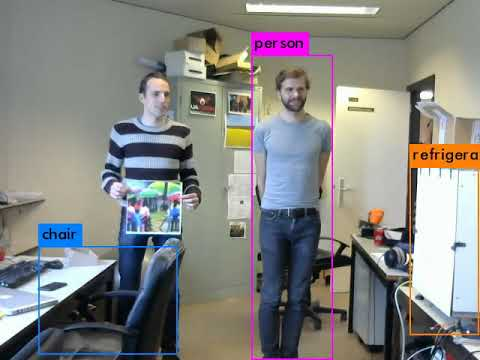

In [17]:
YouTubeVideo('MIbFvK2S9g8')

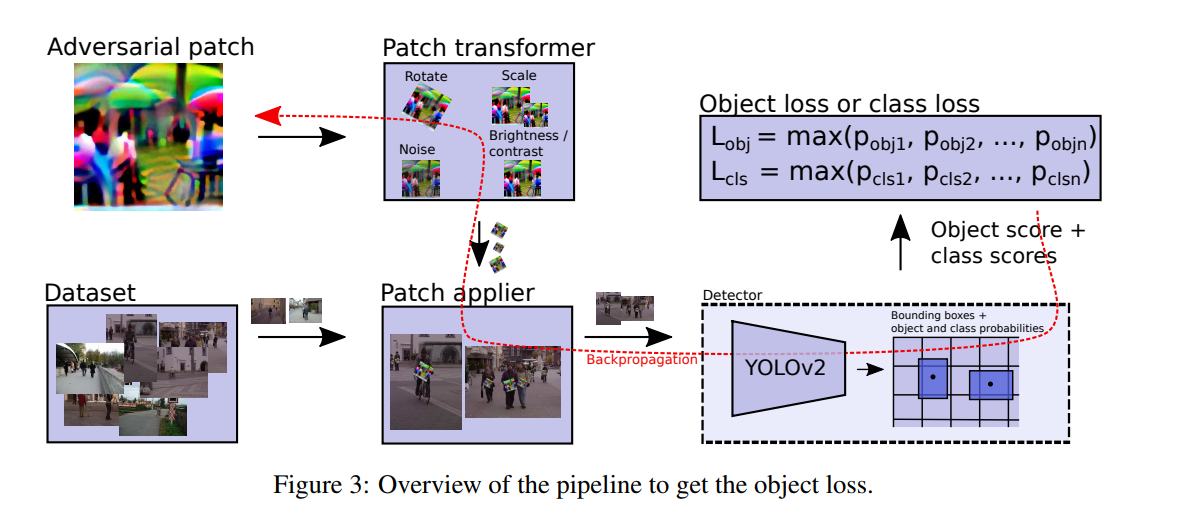

In [19]:
Embed_Image(filename="./data/Screenshot from 2019-08-08 15-34-57.png", width=800, height=800)

### Example of one pixel attack: 

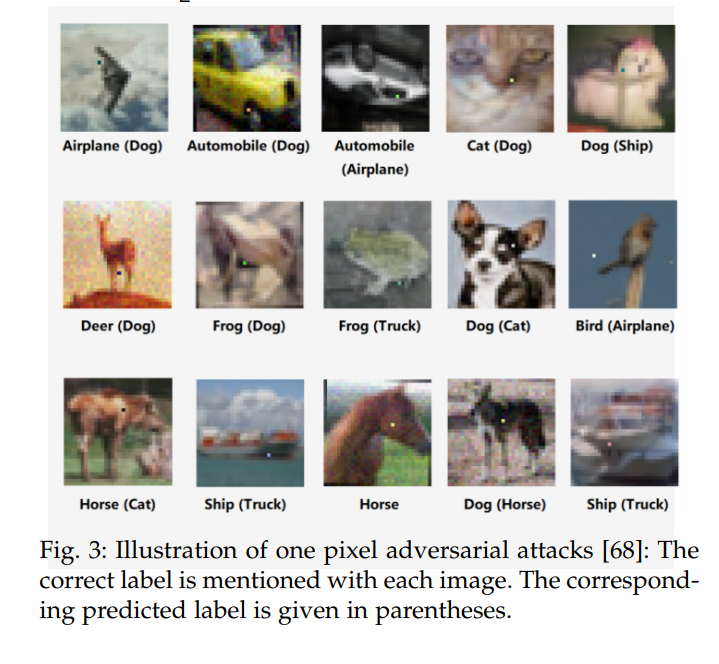

In [21]:
Embed_Image(filename="./data/Screenshot from 2019-08-08 15-42-06.png", width=600, height=600)

### ... But why?

In [64]:
Embed_Image(url="https://miro.medium.com/max/875/1*28L38ebHECfvG5Kv0V6X8A.png", width=500, height=500)

### "The fault is not in our stars, but in our activation functions, for they are linear"

In [63]:
Embed_Image(url="https://miro.medium.com/max/434/1*QindKA4Dt7Ol3CbICMSxWw.png", width=300, height=300)

#### "A key reason why tanh and logistic functions were difficult to train is that those regions of saturation at the tails, where the slope of the activation — and thus the value of the gradient — can get “stuck” very close to 0."

In [68]:
Embed_Image(url="https://miro.medium.com/max/875/1*_Hx_Ndpag2riKlAb843O0Q.png", width=600, height=600)

### Initialize pretrained student model:  

In [26]:
loss_model = get_model('resnet18', 'weights/resnet18_scale_fold0_best.pth.tar')

=> loaded checkpoint (epoch 25)


In [27]:
SSIM_THR = 0.95

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225] 

REVERSE_MEAN = [-0.485, -0.456, -0.406]
REVERSE_STD = [1/0.229, 1/0.224, 1/0.225]

In [28]:
transform = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.Scale(112),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD),
            ])
img2tensor = transforms.Compose([
             transforms.ToTensor(),
             transforms.Normalize(mean=MEAN, std=STD)
             ])

## Data exploration

This is a simple exploration of data structure and submission format.

First of all, run downloader.py. It will create folder 'data' and download competition data and lists. Then unzip imgs.zip to data/imgs/ folder

In [30]:
df = pd.read_csv('data/pairs_list.csv')
df.head()

,source_imgs,target_imgs
0,60f5fb295648e54bd1dc0c859c8fff620ee2eb40.jpg|b...,48f9c10f6e20153d752bbb7248016df80a16f4c3.jpg|2...
1,3e15d19b62ba5c991e8a0d9f85ddb3d8adde9a31.jpg|9...,d53757cc366571251a74d4df211b05b67a279eb2.jpg|d...
2,2cf2e394b1a4fa1d4f71a11deb5eaccfd757d668.jpg|2...,8f9faa1124481d2749ca5ec90c8762fb69a244b7.jpg|b...
3,dcf724dec8125b19bbdc5ab328f3affcdd124a3a.jpg|b...,b57e0e26f0198f3c99626a704849c88506933959.jpg|2...
4,589b3c020dbebb39d52c874dee3c4b84c4ea031a.jpg|5...,76931fc56b77730739eb46ee00da61bd4ef30b83.jpg|d...


Each line contains paths to 5 images of source id and 5 images of target id. All images are stored at 'data/imgs' folder:

In [31]:
imgs_path = 'data/imgs/'
os.listdir(imgs_path)[:10]

['ff2930c2e777fca02708f5b1cf0ee1772b5bd46c.jpg',
 'a8c23e6e57e61e79f59ec9859a5b4637b8c57996.jpg',
 '18599f1dfac060c250faf9bddbba6baf63be797f.jpg',
 '2b425644356187b7baafa6513003c4d83a831b2c.jpg',
 '64612c35899ac8858ecc99e146745e35baef1677.jpg',
 'ac95bf0d494e0dcf18d38add60fae9c4fd3203db.jpg',
 '0b48b12b2134496eded6f6707e1767b3bfafe1e5.jpg',
 '58eb2ec7315b7e2496005e58b4fbd3b2940128e9.jpg',
 '12c67ab29fcadc44f15a3c241b24676788a20d70.jpg',
 '0ea183794fd600aaa874b2ffd59ee7a7b7f201b3.jpg']

Now let's look at some pairs

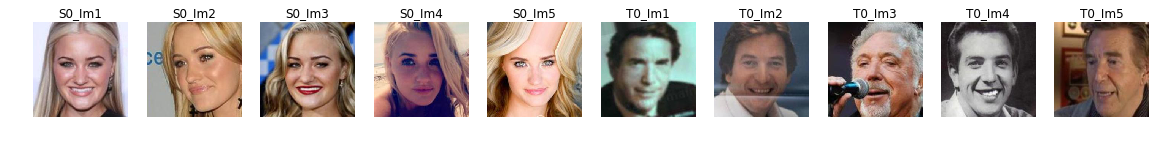

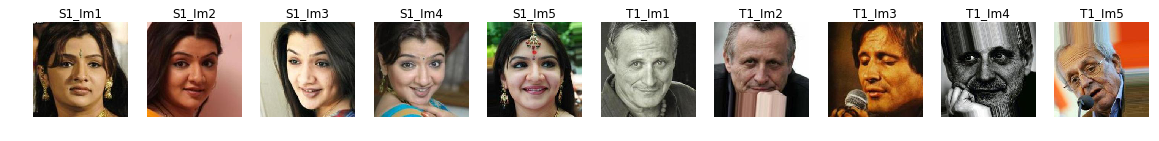

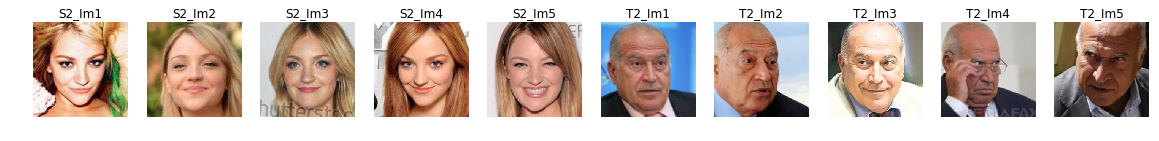

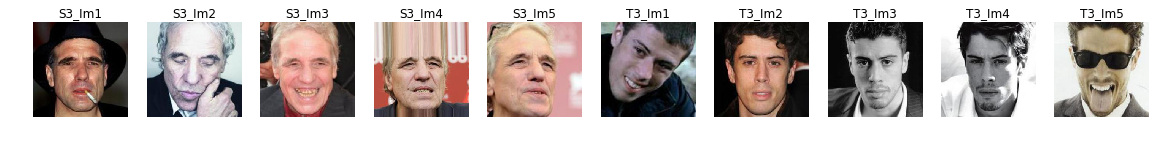

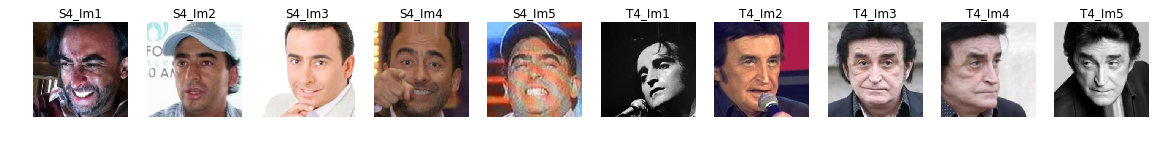

In [32]:
for idx in df.index[:5]:
    source_imgs = df.loc[idx].source_imgs
    target_imgs = df.loc[idx].target_imgs
    plt.figure(figsize=(20, 5))
    for i, img_name in enumerate(source_imgs.split('|'), 1):
        img = Image.open(os.path.join(imgs_path,img_name))
        plt.subplot(1, 10, i)
        plt.title('S{}_Im{}'.format(idx,i))
        plt.axis('off')
        plt.imshow(img)
        
    for i, img_name in enumerate(target_imgs.split('|'), 1):
        img = Image.open(os.path.join(imgs_path,img_name))
        plt.subplot(1, 10, i+5)
        plt.title('T{}_Im{}'.format(idx,i))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

## What is 'small'? SSIM metric

SSIM metric shows the similarity between 2 images. For same images, SSIM=1. For different images -1 < SSIM < 0, SSIM -> 0. In this challenge we consider SSIM distance after Image preprocessing, but before mean/std normalization:

In [35]:
Embed_Image(url="https://scikit-image.org/docs/0.14.x/_images/sphx_glr_plot_ssim_001.png", width=800, height=800)

In [33]:
def img_to_crop(img):
    preprocessing = transforms.Compose([
                    transforms.CenterCrop(224),
                    transforms.Resize(112),
                    ])
    return preprocessing(img)


def crop_to_tensor(img):
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    preprocessing = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=MEAN, std=STD),
                    ])
    img_arr = preprocessing(img).unsqueeze(0).numpy()
    return img_arr

In [34]:
from skimage.io import imsave, imread

In [35]:
img_name=source_imgs.split('|')[2]
img = Image.open(os.path.join(imgs_path,img_name))
img_crop = img_to_crop(img)

SSIM metric is sensitive even to small changes in the image. For example, let's see what happens if we change it by using jpg compression

In [36]:
img_crop.save('./data/tmp.png')
img_crop.save('./data/tmp.jpg')

In [37]:
img_crop_jpg=Image.open('./data/tmp.jpg')
img_crop_png=Image.open('./data/tmp.png')

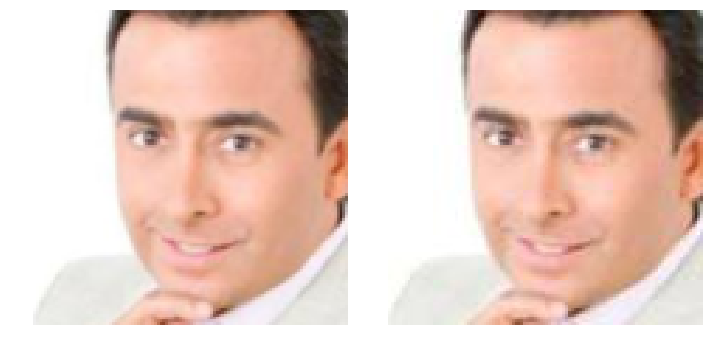

In [38]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img_crop_png)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(img_crop_jpg)

plt.tight_layout()
plt.show()

In [39]:
compare_ssim(np.array(img_crop_jpg), np.array(img_crop_png), multichannel=True)

0.9601905876567466

### .. So: store images as PNGs!

## Create attacks:  

In [43]:
img_pairs = pd.read_csv("./data/pairs_list.csv")

In [29]:
attacker = FGSM_Attacker(loss_model,
                        eps=1e-2,
                        ssim_thr=SSIM_THR,
                        transform=transform,
                        img2tensor=img2tensor,
                        reverse_std=REVERSE_STD, 
                        reverse_mean=REVERSE_MEAN,
                        args={
                            "root":"./data/imgs",
                            "save_root":"./baseline/",
                            "cuda":False,
                            "imshow":True
                        },
                        max_iter=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

TEST: attack on image 60f5fb295648e54bd1dc0c859c8fff620ee2eb40.jpg
TEST: start iterations


  0%|          | 2/1000 [00:00<06:04,  2.74it/s]


TEST: end iterations. SSIM: 0.9483532735358079; Time: 1.10sec



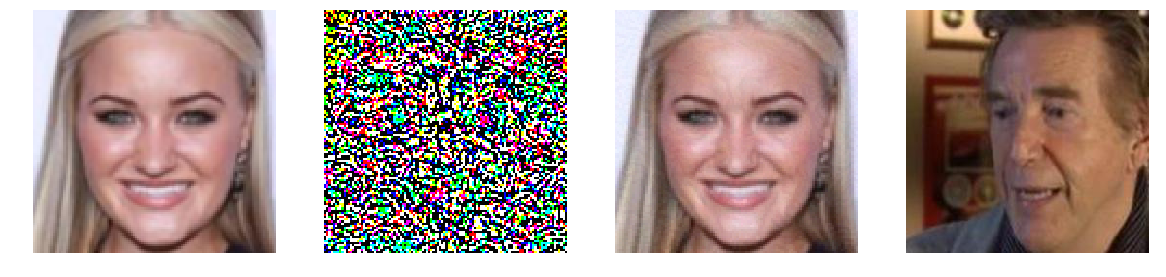

  0%|          | 0/1000 [00:00<?, ?it/s]

TEST: attack on image bc01280fd767ff125d851f2ccc887dce4afa834d.jpg
TEST: start iterations


TEST: end iterations. SSIM: 0.9029663384728573; Time: 0.34sec



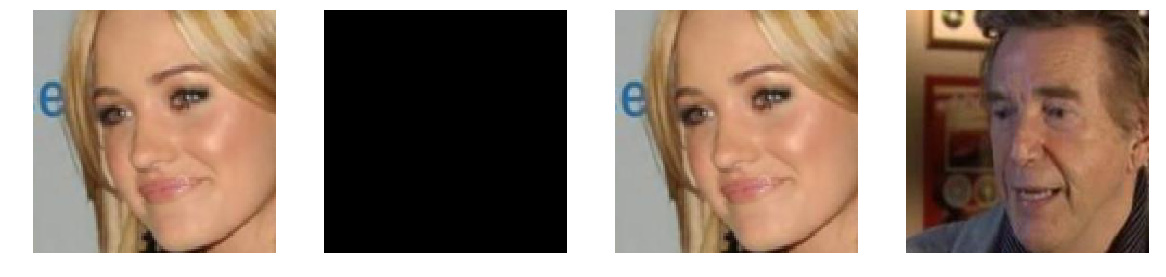

  0%|          | 0/1000 [00:00<?, ?it/s]

TEST: attack on image 254a446a0231b2f96699f254a880513fe9b20f39.jpg
TEST: start iterations


  0%|          | 3/1000 [00:01<06:07,  2.72it/s]


TEST: end iterations. SSIM: 0.9484579063912074; Time: 1.44sec



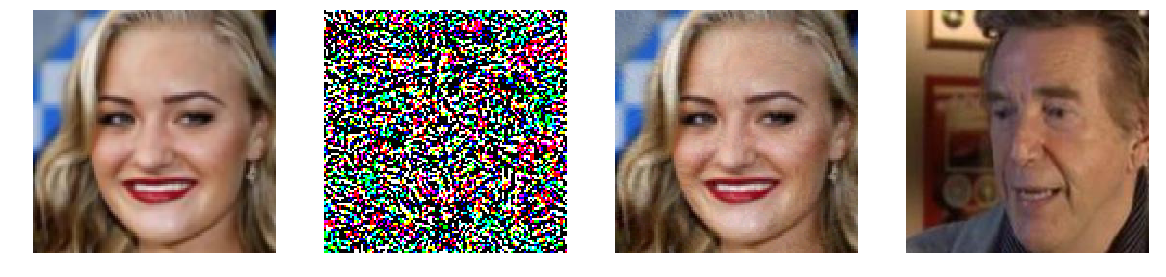

  0%|          | 0/1000 [00:00<?, ?it/s]

TEST: attack on image 3a3a9ad1b942aa4f4c4420b214741cf73d43373e.jpg
TEST: start iterations



KeyboardInterrupt: 

In [44]:
for idx in tqdm(img_pairs.index.values):
    pair_dict = {'source': img_pairs.loc[idx].source_imgs.split('|'),
                 'target': img_pairs.loc[idx].target_imgs.split('|')}

    attacker.attack(pair_dict)